In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from scipy import stats
from sklearn import svm
from sklearn.covariance import EllipticEnvelope, EmpiricalCovariance, MinCovDet

In [12]:
# Generate an arbitrary dataset with 1000 observations, varying cluster separation and random outlier pollution between 0% and 10%
np.random.seed(1)
n_samples = 1000
outliers_fraction = (0.1 * np.random.random_sample())
n_outliers = int(outliers_fraction * n_samples)
n_inliers = int((1-outliers_fraction)*n_samples)
clusters_separation = [0, 1, 2]


# Create the arbitrary dataset with random outlier contamination and varying cluster separation
for i, offset in enumerate(clusters_separation):
    
    # Random data generation
    X1 = 0.3 * np.random.randn(0.5 * n_inliers, 2) - offset
    X2 = 0.3 * np.random.randn(0.5 * n_inliers, 2) + offset
    X = np.r_[X1, X2]
    
    # Add random outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

In [13]:
# fit both a Minimum Covariance Determinant (MCD) robust estimator and an Empirical Covariance to data
robust_cov = MinCovDet().fit(X)
emp_cov = EmpiricalCovariance().fit(X)

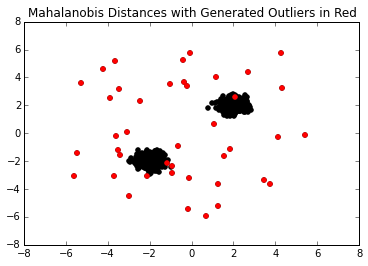

In [14]:
# Display results
fig = plt.figure()

subfig1 = plt.subplot(1, 1, 1)
inlier_plot = subfig1.scatter(X[:, 0], X[:, 1], color='black', label='inliers')
outlier_plot = subfig1.scatter(X[:, 0][-n_outliers:], X[:, 1][-n_outliers:], color='red', label='outliers')
subfig1.set_title("Mahalanobis Distances with Generated Outliers in Red")

In [15]:
# The above chart shows a number of red dots equal to the randomly generated n_outliers variable.
# However, I declared an assumption in the main document that I would not know the outlier contamination
# Therefore, I can not use the "n_outliers" variable for the second stage of this analysis.
# Instead, I must ignore that I have that number stored from the task of generating the data and 
# estimate it from the Mahalanobis Distances as if this data was something that I was completely naive to.
# Also, to graph shows red dots near or invading my black clusters (depending on random seed), so I disagree 
# with some of the assignments and would have assigned fewer outliers by hand.

emp_mahal = emp_cov.mahalanobis(X - np.mean(X, 0)) ** .333
robust_mahal = robust_cov.mahalanobis(X - robust_cov.location_) ** .333
ave_mahal = (emp_mahal + robust_mahal)/2
mean = np.mean(ave_mahal)
sd = np.std(ave_mahal)
limit = mean + (3*sd)

contamination = np.float(np.sum(ave_mahal > limit)) / np.float(np.sum(ave_mahal > -100))

In [16]:
contamination

0.025025025025025027

In [17]:
# Just for laughs, compare this new estimate to the outlier contamination rate imposed at random during data generation, 
# and there are indeed fewer assignments than before, exactly as desired:

(np.float(n_outliers))/(np.float(n_samples))

0.041

In [22]:
# Moving on, I take that new estimate of outlier contamination, and make it an assumption as I compare
# two outlier detection tools, a single class support vector machine tuned for outlier detection (better 
# with separated clusters or strongly non-Gaussian distributions, and a Robust Covariance Estimator (a.k.a
# elliptic envelope...better for Gaussian distributions, but fails otherwise)

classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                     kernel="rbf", gamma=0.1),
    "Robust Covariance Estimator": EllipticEnvelope(contamination=.1)}

# Compare classifiers 

xx, yy = np.meshgrid(np.linspace(-10, 10, 500), np.linspace(-10, 10, 500))

contaminants = np.sum(ave_mahal > limit)

ground_proj = np.ones(n_samples, dtype=int)
ground_proj[-contaminants:] = 0

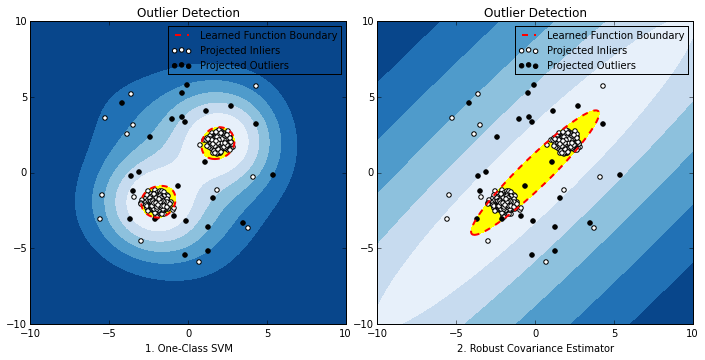

In [23]:
# Fit and Plot

plt.figure(figsize=(10, 5))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fit the data and tag outliers
    clf.fit(X)
    y_pred = clf.decision_function(X).ravel()
    threshold = stats.scoreatpercentile(y_pred,100 * outliers_fraction)
    y_pred = y_pred > threshold
    n_errors = np.sum((y_pred != ground_proj))
    
    # plot the levels lines and the points
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    subplot = plt.subplot(1, 2, i + 1)
    subplot.set_title("Outlier Detection")
    subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
    a = subplot.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='yellow')
    b = subplot.scatter(X[:-contaminants, 0], X[:-contaminants, 1], c='white')
    c = subplot.scatter(X[-contaminants:, 0], X[-contaminants:, 1], c='black')
    subplot.axis('tight')
    subplot.legend(
         [a.collections[0], b, c],
         ['Learned Function Boundary', 'Projected Inliers', 'Projected Outliers'],
         prop=matplotlib.font_manager.FontProperties(size=10))
    subplot.set_xlabel("%d. %s" % (i + 1, clf_name))
    subplot.set_xlim((-10, 10))
    subplot.set_ylim((-10, 10))
plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)

plt.show()